In [17]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation
from IPython.display import HTML



In [18]:
class MaizField:
    def __init__(self, size=10):
        self.original_size = size  # Tamaño original
        self.size = size * 2  # Duplicar el tamaño
        self.field = np.zeros((self.size, self.size))  # Inicializar con ceros
        self.tractores_positions = [(0, 0)]  # Posiciones iniciales de los tractores
        self.place_original_maiz()  # Colocar maíz en la parte original
        self.total_maiz = np.sum(self.field)

    def place_original_maiz(self):
        for x in range(self.original_size):
            for y in range(self.original_size):
                self.field[x, y] = 1

    def reset(self):
        self.field = np.zeros((self.size, self.size))  # Resetear con ceros
        self.place_original_maiz()  # Colocar el maíz nuevamente
        # self.tractores_positions = [(0, 0), (0, self.size - 1)]
        self.tractores_positions = [(0, 0)]
        self.total_maiz = np.sum(self.field)
        return [self.state_to_index(pos) for pos in self.tractores_positions]

    def state_to_index(self, state):
        return state[0] * self.size + state[1]

    def index_to_state(self, index):
        return (index // self.size, index % self.size)

    def step(self, actions):
        rewards = []
        new_positions = []

        # Process actions for each tractor
        for i, action in enumerate(actions):
            x, y = self.tractores_positions[i]
            if action == 0 and x > 0: x -= 1  # Arriba
            elif action == 1 and x < self.size - 1: x += 1  # Abajo
            elif action == 2 and y > 0: y -= 1  # Izquierda
            elif action == 3 and y < self.size - 1: y += 1  # Derecha

            new_positions.append((x, y))

        # # Verificar colisiones
        # if new_positions[0] == new_positions[1]:
        #     # return [self.state_to_index(pos) for pos in self.tractores_positions], [-1, -1]  # Penalización por colisión
        #     return [self.state_to_index(pos) for pos in self.tractores_positions], [-1]  # Penalización por colisión
        
        if len(new_positions) > 1 and new_positions[0] == new_positions[1]:
            return [self.state_to_index(pos) for pos in self.tractores_positions], [-1, -1]

        # Actualizar posiciones y recompensas
        for i, pos in enumerate(new_positions):
            self.tractores_positions[i] = pos
            reward = 1 if self.field[pos] == 1 else -1
            self.field[pos] = 0  # Recolectar el maíz
            self.total_maiz -= 1
            rewards.append(reward)

        return [self.state_to_index(pos) for pos in self.tractores_positions], rewards



In [19]:
class QLearningAgent:
    def __init__(self, states, actions, learning_rate=0.1, discount_factor=0.9, exploration_rate=0.1):
        self.q_table = np.zeros((states, actions))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_rate:
            return random.choice([0, 1, 2, 3])  # Explorar
        else:
            return np.argmax(self.q_table[state])  # Explotar

    def update_q_table(self, state, action, reward, new_state):
        predict = self.q_table[state, action]
        target = reward + self.discount_factor * np.max(self.q_table[new_state])
        self.q_table[state, action] += self.learning_rate * (target - predict)


In [20]:
def train(episodes=1000, steps_per_episode=100):
    field = MaizField(size=10)  # Adjust size if needed
    agent1 = QLearningAgent(field.size**2, 4)  # Initialize the agent
    paths = []  # To store paths for each episode

    for episode in range(episodes):
        states = field.reset()
        path = [(states[0], None)]  # Initial state with no action
        total_reward = 0

        for step in range(steps_per_episode):
            action1 = agent1.choose_action(states[0])
            new_states, rewards = field.step([action1])
            agent1.update_q_table(states[0], action1, rewards[0], new_states[0])

            path.append((new_states[0], action1))  # Store state and action
            states = new_states
            total_reward += rewards[0]

            if field.total_maiz == 0:  # Check if the episode should end
                break

        paths.append(path)  # Store the path for the episode

    return paths

paths = train(episodes=5, steps_per_episode=100)  # Run training and store paths


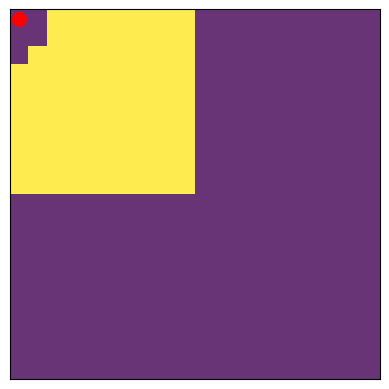

In [21]:
# Initialize the environment and agent
field = MaizField(size=10)
agent = QLearningAgent(field.size**2, 4)

# Function to plot the environment
def animation_plot(field, ax):
    ax.clear()
    ax.imshow(field.field, cmap='viridis', alpha=0.8)  # Use the field matrix for visualization
    for pos in field.tractores_positions:
        ax.scatter(pos[1], pos[0], color='red', s=100)  # Tractor positions
    ax.set_xticks([])
    ax.set_yticks([])

# Update function for the animation
def update(frame, field, agent, ax):
    state = field.state_to_index(field.tractores_positions[0])  # Convert position to state
    action = agent.choose_action(state)  # Choose action
    field.step([action])  # Perform the action
    animation_plot(field, ax)

fig, ax = plt.subplots()

# Reset the environment for the animation
field.reset()

# Create the animation
animation = FuncAnimation(fig, lambda frame: update(frame, field, agent, ax), frames=100, interval=100)

# Display the animation in Jupyter Notebook
HTML(animation.to_jshtml())